In [1]:
import numpy as np
import pandas as pd
pd.set_option('precision', 3)
from itertools import compress
import copy, sys, os, warnings, shutil
import matplotlib.pyplot as plt
from pyirr import intraclass_correlation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold, permutation_test_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, confusion_matrix, make_scorer
from scipy.stats import spearmanr, mannwhitneyu
from compare_auc_delong import delong_roc_test
from time import strftime, localtime, sleep
import shap
import pickle
from IPython.display import display, Javascript

oldPath = os.path.join(os.path.expanduser('~'), 'Documents/GitHub/icrpythonradiomics/machineLearning')
if os.path.exists(oldPath) and oldPath in sys.path:
    sys.path.remove(oldPath)
sys.path.append(os.path.join(os.path.expanduser('~'), 'Documents/git/git_icrpythonradiomics/machineLearning'))
from featureSelection import featureSelection_correlation as featSelCorr

# validation parameters
n_splits = 10
n_repeats = 100

# Two experiments need to be run with this variable True and False corresponding to flipping the target variable
# Although this has no effect on the models or the ROCs (other than the sign of the coefficients), it does have 
# an important effect on the net benefit curves, and this effect is not simply flipping the axes.  
# We could derive the ROCs etc. from only one model run, but I'm doing it this way because it's easier.
invertTarget = True

In [2]:
%%capture

dataFolder = os.path.join(os.path.expanduser('~'), 'Dropbox (ICR)/CLINMAG/Radiomics/ECE_Prostate_Semantic')

outputFolder = os.path.join(dataFolder, 'RadiomicsModelling', strftime("%Y%m%d_%H%M", localtime()))

# output folders
os.mkdir(outputFolder)
os.mkdir(os.path.join(outputFolder, 'code'))
outputFolderFigures = os.path.join(outputFolder, 'figures')
os.mkdir(outputFolderFigures)
outputFolderPickles = os.path.join(outputFolder, 'pickles')
os.mkdir(outputFolderPickles)

# copy this notebook (will save and copy again at the end of the notebook)
theNotebook = 'RadiomicsSemanticModelling_v2.0.ipynb'
notebookPath = os.path.join(os.path.abspath(""), theNotebook)
notebookDestin = os.path.join(outputFolder, 'code', theNotebook)
shutil.copyfile(notebookPath, notebookDestin)

# a module I wrote
user = os.path.expanduser("~")
file2 = os.path.join(user, 'Documents/git/git_icrpythonradiomics/machineLearning/featureSelection.py')
shutil.copyfile(file2, os.path.join(outputFolder, 'code', 'featureSelection.py'))

# expoert the conda environment info
os.system('conda env export > "' + os.path.join(outputFolder, 'code', 'environmentTest.yml') + '"')

In [3]:
def confusion_matrix_thresholds(yTrue, yScore, thresholds):
    tnArr, fpArr, fnArr, tpArr = [], [], [], []
    nSamples = len(yTrue)
    for thresh in thresholds:
        tn, fp, fn, tp = confusion_matrix(yTrue, yScore>thresh, labels=[0, 1]).ravel()
        tnArr.append(tn)
        fpArr.append(fp)
        fnArr.append(fn)
        tpArr.append(tp)
    return np.array(tnArr), np.array(fpArr), np.array(fnArr), np.array(tpArr)

In [4]:
def calculate_fnr(y_true, y_pred, pt=0):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred > pt).ravel()
    return fn/(fn + tp)


def calculate_fpr(y_true, y_pred, pt=0):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred > pt).ravel()
    return fp/(fp + tn)


def calculate_net_benefit_score(y_true, y_pred, pt=0):
    _, fp, _, tp = confusion_matrix(y_true, y_pred > pt).ravel()
    net_benefit = (tp - fp * (pt / (1 - pt))) / len(y_true)
    return net_benefit


def unpack_scorers(cvr):

    thresh_FNR, thresh_FPR, thresh_DCA, value_DCA, value_FNR, value_FPR = [], [], [], [], [], []
    
    for key, value in cvr.items():
        if 'test_FNR' in key:
            thresh_FNR.append(float(key.replace('test_FNR_','')))
            value_FNR.append(np.mean(value))
        if 'test_FPR' in key:
            thresh_FPR.append(float(key.replace('test_FPR_','')))
            value_FPR.append(np.mean(value))
        if 'test_DCA' in key:
            thresh_DCA.append(float(key.replace('test_DCA_','')))
            value_DCA.append(np.mean(value))

    idxFNR = np.argsort(thresh_FNR)
    idxFPR = np.argsort(thresh_FPR)
    idxDCA = np.argsort(thresh_DCA)

    FNR = {'thresholds': [thresh_FNR[idx] for idx in idxFNR],
           'values': [value_FNR[idx] for idx in idxFNR]}
    
    FPR = {'thresholds': [thresh_FPR[idx] for idx in idxFPR],
           'values': [value_FPR[idx] for idx in idxFPR]}

    DCA = {'thresholds': [thresh_DCA[idx] for idx in idxDCA],
           'values': [value_DCA[idx] for idx in idxDCA]}
    
    return FNR, FPR, DCA

# Make dictionary of scorers, each of which will compute one point on the FNR and FPR curves.
# The dictionary key is used to keep track of the threshold value that was used.
scorers = {}

# Don't use 0 and 1 as endpoints as this causes numerical underflow.
ptArr = np.round(np.linspace(0, 1, 101),2)
ptArr[0] = np.round(0.0001,4)
ptArr[-1] = np.round(0.9999,4)

for pt in ptArr:
    scorers['FNR_' + str(pt)] = make_scorer(calculate_fnr, pt = pt, needs_proba=True)
    scorers['FPR_' + str(pt)] = make_scorer(calculate_fpr, pt = pt, needs_proba=True)
    scorers['DCA_' + str(pt)] = make_scorer(calculate_net_benefit_score, pt = pt, needs_proba=True)

# standard scorers    
scorers['roc_auc'] = 'roc_auc'
scorers['accuracy'] = 'accuracy'
scorers['f1'] = 'f1'

## Load two reader semantic data (for computing ICCs) 

In [5]:
twoReaderFile = os.path.join(dataFolder, 'ECE_Semantic_Data', 'GG_MG.xlsx')

# read spreadsheet
df = pd.read_excel(twoReaderFile, sheet_name='GG_MG', engine='openpyxl')

# remove features, as with the discovery/test data
df.drop(['IndexLesion_GG', 'IndexLesionMG', 'GlobalStageGG', 'GlobalStageMG'], axis=1, inplace=True)

# remove rows with missing data - need to check that this leaves the same patients for dfGG as in the discovery data set
df.dropna(inplace=True)

# split to each reader
dfGG = df.filter(regex = 'GG|PID', axis = 1)
dfMG = df.filter(regex='MG|PID', axis=1)

# match column names by removing subscripts
dfGG = dfGG.rename(columns=lambda x: x.replace('_GG','').replace('GG',''))
dfMG = dfMG.rename(columns=lambda x: x.replace('_MG','').replace('MG',''))

# change some column names to match the discovery/test data sets
renameDict = {'LocIndexL':'AnatDev01',
              'LocAnat':'AnatDev02',
              'Division':'AnatDev03',
              'DivisionLat':'AnatDev04',
              'LesionSize':'MajorLengthIndex',
              'SmoothCapsularBulgin':'SmoothCapsularBulging',
              'UnsharpMargins':'UnsharpMargin',
              'irregularContour':'IrregularContour',
              'BlackEstrition':'BlackEstritionPeripFat',
              'measurableECE':'MeasurableECE',
              'retroprostaticAngleObl':'RetroprostaticAngleOblit'}
dfGG.rename(renameDict, axis=1, inplace=True)
dfMG.rename(renameDict, axis=1, inplace=True)

# highsignalT1FS is missing from this spreadsheet, so fill in with default value.
# Fortunately, this feature is not selected in the final model, but we need it there for compatibility.
dfGG.loc[:, 'highsignalT1FS'] = 0
dfMG.loc[:, 'highsignalT1FS'] = 0

iccDict = {}
for col in dfGG.drop(['PID', 'highsignalT1FS'], axis=1):
    data = np.stack((dfGG[col], dfMG[col]), axis=1)
    iccDict['semantic_' + col] = intraclass_correlation(data, "twoway", "agreement").value

## Read and prepare radiomics data (discovery and test) 

In [6]:
radiomicsFile = os.path.join(dataFolder, 'ECE_Semantic_Data', 'radiomicFeatures__202209271126.csv')

dfRad = pd.read_csv(radiomicsFile)
dfRad.drop(list(dfRad.filter(regex = 'source')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'diagnostics')), axis = 1, inplace = True)
dfRad.drop(list(dfRad.filter(regex = 'histogram')), axis = 1, inplace = True)

# remove feature sets we don't want to use and remove string from the one that is left
dfRad.drop(list(dfRad.filter(regex = 'noNormalize|maskNormalize')), axis = 1, inplace = True)
dfRad = dfRad.rename(columns=lambda x: x.replace('normalized_',''))

# To match the semantic data file
dfRad['StudyPatientName'] = dfRad['StudyPatientName'].str.replace('_',' ')

# sensible prefix 
dfRad = dfRad.rename(columns=lambda x: x.replace('original','radiomics'))

# split off the repro rows
dfRep1 = dfRad.loc[dfRad.StudyPatientName.str.contains('rep'),:].copy()
dfRep1['StudyPatientName'] = dfRep1['StudyPatientName'].str.replace(' repro','')
dfRep1.sort_values('StudyPatientName', axis=0, inplace=True)
dfRep1.reset_index(inplace=True, drop=True)

# remove repro from main data frame
dfRad = dfRad.loc[~dfRad.StudyPatientName.str.contains('rep'),:]
dfRad.reset_index(inplace=True, drop=True)

# main data rows for same patients as repro
dfRep0 = dfRad.loc[dfRad['StudyPatientName'].isin(dfRep1['StudyPatientName'])].copy()
dfRep0.sort_values('StudyPatientName', axis=0, inplace=True)
dfRep0.reset_index(inplace=True, drop=True)

for col in dfRep1.drop('StudyPatientName', axis=1):
    data = np.stack((dfRep0[col], dfRep1[col]), axis=1)
    iccDict[col] = intraclass_correlation(data, "twoway", "agreement").value

# Remove non-reproducible radiomics features

In [7]:
# remove non-reproducible features
iccThreshold = 0.75
reproducibleFeatures = [key for key, value in iccDict.items() if value>iccThreshold and 'radiomics' in key]
reproducibleFeatures.insert(0,'StudyPatientName')
dfRad = dfRad[reproducibleFeatures]

## Read and prepare semantic data (discovery and test)

In [8]:
discoveryFile = os.path.join(dataFolder, 'ECE_Semantic_Data', 'discovery.csv')
externalTestFile = os.path.join(dataFolder, 'ECE_Semantic_Data', 'external.csv')
    
# load data
dfTrain = pd.read_csv(discoveryFile)
dfTest  = pd.read_csv(externalTestFile)

# drop features we are not going to use for classification
dropFeatures = ['Gleason biopsy', 'TumorGradeMRI'] #, 'AnatDev01', 'AnatDev02', 'AnatDev03', 'AnatDev04']
dfTrain.drop(dropFeatures, inplace=True, axis=1)
dfTest.drop(dropFeatures, inplace=True, axis=1)

# change this feature to have a more descriptive name
dfTrain.insert(1, 'Gleason>(3+4)', dfTrain['GleasonBinary'])
dfTest.insert(1, 'Gleason>(3+4)', dfTest['GleasonBinary'])
dfTrain.drop('GleasonBinary', axis=1, inplace=True)
dfTest.drop('GleasonBinary', axis=1, inplace=True)

# make these features binary 0/1
toBinary = ['SmoothCapsularBulging' ,'CapsularDisruption', 'UnsharpMargin', 'IrregularContour', 'BlackEstritionPeripFat', 'MeasurableECE', 'RetroprostaticAngleOblit', 'highsignalT1FS']
for tb in toBinary:
    dfTrain[tb]  = dfTrain[tb].map(dict(YES=1, NO=0))
    dfTest[tb] = dfTest[tb].map(dict(YES=1, NO=0))

# one-hot encode PIRADS
dfTrain.insert(4, 'PIRADS_4', (dfTrain['IndLesPIRADS_V2']==4).astype(int))
dfTrain.insert(4, 'PIRADS_5', (dfTrain['IndLesPIRADS_V2']==5).astype(int))
dfTrain.drop('IndLesPIRADS_V2', axis=1, inplace=True)
dfTest.insert(4, 'PIRADS_4', (dfTest['IndLesPIRADS_V2']==4).astype(int))
dfTest.insert(4, 'PIRADS_5', (dfTest['IndLesPIRADS_V2']==5).astype(int))
dfTest.drop('IndLesPIRADS_V2', axis=1, inplace=True)

# log transform some features to get rid of long tail
dfTrain.ProstateVolume = np.log(dfTrain.ProstateVolume)
dfTest.ProstateVolume = np.log(dfTest.ProstateVolume)
dfTrain.PSA = np.log(dfTrain.PSA)
dfTest.PSA = np.log(dfTest.PSA)

# is missing in test and training, so replace both with median from the training data
psaTrainMedian = np.nanmedian(np.array(dfTrain.PSA))
dfTrain.PSA.fillna(psaTrainMedian, inplace=True)
dfTest.PSA.fillna(psaTrainMedian, inplace=True)

# this feature is not selected in the semantic model, so this has no effect
# fill in with the most common value
dfTest.highsignalT1FS.fillna(0, inplace=True)

# add interaction feature
dfTrain['Gleason x mECE'] = dfTrain['Gleason>(3+4)']*dfTrain['MeasurableECE']
dfTest['Gleason x mECE'] = dfTest['Gleason>(3+4)']*dfTest['MeasurableECE']

dfTrain['Gleason x PIRADS_4'] = dfTrain['Gleason>(3+4)']*dfTrain['PIRADS_4']
dfTrain['Gleason x PIRADS_5'] = dfTrain['Gleason>(3+4)']*dfTrain['PIRADS_5']
dfTest['Gleason x PIRADS_4'] = dfTest['Gleason>(3+4)']*dfTest['PIRADS_4']
dfTest['Gleason x PIRADS_5'] = dfTest['Gleason>(3+4)']*dfTest['PIRADS_5']

# add string to names for easy manipulation of groups
clinicalFeatures = ['Gleason>(3+4)', 'ProstateVolume', 'PSA', 'PIRADS_4', 'PIRADS_5', 'Gleason x PIRADS_5', 'Gleason x PIRADS_4']
semanticFeatures = list(set(dfTrain.columns) - set(clinicalFeatures) - set(['PID', 'ECE_Pathology']))
dfTrain = dfTrain.rename(columns=lambda x: 'clinical_' + x if x in clinicalFeatures else x)
dfTest = dfTest.rename(columns=lambda x: 'clinical_' + x if x in clinicalFeatures else x)
dfTrain = dfTrain.rename(columns=lambda x: 'semantic_' + x if x in semanticFeatures else x)
dfTest = dfTest.rename(columns=lambda x: 'semantic_' + x if x in semanticFeatures else x)

# merge radiomics 
dfTrain = dfTrain.merge(dfRad, left_on='PID', right_on='StudyPatientName')
dfTest = dfTest.merge(dfRad, left_on='PID', right_on='StudyPatientName')
dfTrain = dfTrain.drop(['PID', 'StudyPatientName'], axis=1)
dfTest = dfTest.drop(['PID', 'StudyPatientName'], axis=1)


# Invert sense of the target variable and MeasurableECE

i.e. target=1 implies "no ECE", target=0 implies "ECE present"

In [9]:

# switch sense of the target variable and MeasureableECE
if invertTarget:
    dfTrain['noECE'] = 1 - dfTrain['ECE_Pathology']
    dfTest['noECE'] = 1 - dfTest['ECE_Pathology']
    dfTrain.drop('ECE_Pathology', axis=1, inplace=True)
    dfTest.drop('ECE_Pathology', axis=1, inplace=True)

    dfTrain['semantic_noMeasECE'] = 1 - dfTrain['semantic_MeasurableECE']
    dfTest['semantic_noMeasECE'] = 1 - dfTest['semantic_MeasurableECE']
    dfTrain.drop('semantic_MeasurableECE', axis=1, inplace=True)
    dfTest.drop('semantic_MeasurableECE', axis=1, inplace=True)
    
    target = 'noECE'
    measECEskip = 'semantic_noMeasECE'
    
else:
    
    target = 'ECE_Pathology'
    measECEskip = 'semantic_MeasurableECE'
    


## Main model fitting function 

In [10]:
def fitModel(dfTrain, dfTest, pipeline, label=None, pickleFile=None, coefDisplayFunction=None, keepRegex=None, removeList = None, permutationTest=False):

    if pickleFile is not None and os.path.exists(pickleFile):
        with open(pickleFile, 'rb') as handle:
            out = pickle.load(handle)

    else:
    
        # reproducible execution
        seed = 42
        np.random.seed(seed)

        # get training and test data
        XTrain = dfTrain.drop(target, axis=1).copy()
        XTest = dfTest.drop(target, axis=1).copy()
        yTrain = dfTrain[target].copy()
        yTest = dfTest[target].copy()

        # keep features as indicated
        if keepRegex is not None:
            XTrain = XTrain.filter(regex = keepRegex)
            XTest = XTest.filter(regex = keepRegex)

        # remove listed features
        if removeList is not None:
            for item in removeList:
                if item in XTrain:
                    XTrain.drop(item, axis=1, inplace=True)
                    XTest.drop(item, axis=1, inplace=True)

        # make sure correlationSelector will not remove any clinical or semantic features
        if pipeline.steps[0][0] == 'correlationSelector':
            pipeline.steps[0][1].namedColumnsKeep = [x for x in XTrain.columns if 'clinical' in x or 'semantic' in x]

        # drop low variance radiomics features (in practice this only includes radiomics_glcm_Idmn)
        CoV = pd.DataFrame(XTrain.apply(lambda x: np.std(x)/np.mean(x), axis=0))
        lowVarianceFeatures = CoV.loc[np.abs(CoV.loc[:,0])<0.01,:].index.values.tolist()
        lowVarianceFeatures = [x for x in lowVarianceFeatures if 'clinical' not in x and 'semantic' not in x]
        XTrain.drop(lowVarianceFeatures, axis = 1, inplace = True)
        XTest.drop(lowVarianceFeatures, axis = 1, inplace = True)

        # fit to all data
        pipeline.fit(XTrain, yTrain)

        # cross-validate
        outer_cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
        cv_result = cross_validate(pipeline, 
                                   XTrain, 
                                   yTrain, 
                                   cv=outer_cv, 
                                   scoring=scorers,
                                   return_estimator=True, 
                                   verbose=0, 
                                   n_jobs=-1)

        # print CV scores
        AUC_CV = np.mean(cv_result['test_roc_auc'])
        Accuracy_CV = np.mean(cv_result['test_accuracy'])
        F1_CV = np.mean(cv_result['test_f1'])

        FNR, FPR, DCA = unpack_scorers(cv_result)

        # permutation testing
        if permutationTest:
            outer_cv.n_repeats = 1

            warnings.simplefilter("ignore")
            os.environ["PYTHONWARNINGS"] = "ignore"
            #
            scoreDirect, perm_scores, pValueDirect = permutation_test_score(pipeline, 
                                                                            XTrain, 
                                                                            yTrain, 
                                                                            scoring="roc_auc",
                                                                            cv=outer_cv, 
                                                                            n_permutations=n_permutations,
                                                                            verbose=0, n_jobs=-1)
            #
            warnings.simplefilter('default')
            os.environ["PYTHONWARNINGS"] = 'default'

            # pValueDirect is computed using scoreDirect and assumes only one outer CV run
            # We have used repeated outer CV, so the following code correctly computes the p-value of our repeated CV performance estimate
            # Actually, it doesn't seem to make much difference, so am relaxed about that.

            p_values = []
            scores_roc_auc = np.mean(np.reshape(cv_result['test_roc_auc'], (n_repeats, -1)), axis=1)
            for score in scores_roc_auc:
                p_values.append((np.count_nonzero(perm_scores >= score) + 1) / (n_permutations + 1))
            pValue_CV = np.mean(p_values)
            print('p-value       = ' + str(pValue_CV.round(4)))
        else:
            pValue_CV = None


        # get scores and predicted class info
        test_score = pipeline.predict_proba(XTest)[:, 1]
        test_class = pipeline.predict(XTest)

        # test scores from main model
        testAUROC = roc_auc_score(yTest, test_score)
        testAccuracy = accuracy_score(yTest, test_class)
        testF1 = f1_score(yTest, test_class)

        pValueTest = mannwhitneyu(test_score[yTest==0], test_score[yTest==1], alternative='two-sided').pvalue

        out = {'label':label,
               'test_AUC':testAUROC,
               'test_score':test_score,
               'test_class':test_class,
               'test_accuracy':testAccuracy,
               'test_f1':testF1,
               'test_pValue':pValueTest,
               'AUC_CV':AUC_CV,
               'Accuracy_CV':Accuracy_CV,
               'F1_CV':F1_CV,
               'pValue_CV':pValue_CV,
               'FNR_CV':FNR,
               'FPR_CV':FPR,
               'DCA_CV':DCA,
               'XTrain':XTrain.copy(),
               'XTest':XTest.copy(),
               'yTrain':yTrain.copy(),
               'yTest':yTest.copy(),
               'pipeline':pipeline,
               'cv_result':cv_result
              }

    print('AUCROC   (CV) = ' + str(out['AUC_CV'].round(3)) + ' \u00B1 ' + str(np.round(np.std(out['cv_result']['test_roc_auc']),3)))
    print('Accuracy (CV) = ' + str(out['Accuracy_CV'].round(3)) + ' \u00B1 ' + str(np.round(np.std(out['cv_result']['test_accuracy']),3)))
    print('F1       (CV) = ' + str(out['F1_CV'].round(3)) + ' \u00B1 ' + str(np.round(np.std(out['cv_result']['test_f1']),3)))
    
    
    # print the test performance metrics
    print('\nAUCROC   (test) = ' + str(np.round(out['test_AUC'],3)))
    print('Accuracy (test) = ' + str(np.round(out['test_accuracy'],3)))
    print('F1       (test) = ' + str(np.round(out['test_f1'],3)))
    print('p-value  (test) = ' + str(np.round(out['test_pValue'], 6)))

    if coefDisplayFunction is not None:
        dfCoefResults = coefDisplayFunction(out['pipeline'], out['XTrain'].columns, out['cv_result'])

        
    if pickleFile is not None:
        with open(pickleFile, 'wb') as handle:
            pickle.dump(out, handle)

    
    return out

## Three logistic regression pipelines 

In [11]:
# basic logistic regression, no regularisation
pipelineLRsimple = Pipeline(steps=[('scaler', StandardScaler()),
                                   ('lr', LogisticRegression(penalty='none'))])

# logistic regression with lasso
pipelineLRlasso = Pipeline(steps=[('scaler', StandardScaler()), 
                                  ('lr', LogisticRegressionCV(Cs=20, 
                                                              cv=10, 
                                                              solver="liblinear",
                                                              max_iter=10000, 
                                                              penalty='l1',
                                                              random_state=42))])

# logistic regression with lasso, preceded by correlation feature reduction
# fitModel function will modify pipeline to make sure the clinical and semantic features are not affected by
# correlation feature reduction
pipelineCfrLRlasso = Pipeline([('correlationSelector', featSelCorr(threshold=0.9,
                                                                   exact=False,
                                                                   featureGroupHierarchy=['shape_MeshVolume',
                                                                                          'shape',
                                                                                          'firstorder'])),
                               ('scaler', StandardScaler()),
                               ('lr', GridSearchCV(estimator=LogisticRegression(solver="liblinear", 
                                                                                max_iter=10000, 
                                                                                penalty='l1'), 
                                                   param_grid={'C':np.logspace(np.log10(0.05), np.log10(50), 20)}, 
                                                   cv=StratifiedKFold(n_splits=10), 
                                                   refit=True, 
                                                   verbose=0, 
                                                   scoring='neg_log_loss', 
                                                   n_jobs=1))])


## Functions to display non-zero logistic regression coeffients for the pipelines

In [12]:
def coefDispFunLRsimple(pipeline, featureNames, dummy):
    dfCoefResults = pd.DataFrame({'Feature':[x.replace('clinical_','') for x in featureNames], 
                                  'Coeff':np.squeeze(pipeline._final_estimator.coef_)})
    dfCoefResults.sort_values(by='Coeff', key=abs, inplace=True, ascending=False)
    display(dfCoefResults.style.hide_index())
    print(dfCoefResults.to_string(index=False))

def coefDispFunLRlasso(pipeline, featureNames, cv_result):

    # get frequency that features are non-zero across the repeated cv splits
    coef_cv = np.zeros((len(cv_result['estimator']), len(featureNames)))
    for n, res in enumerate(cv_result['estimator']):
        coef_cv[n, :] = res._final_estimator.coef_
    coef_freq = np.sum(coef_cv != 0, axis=0) / (n_repeats * n_splits)

    # put icc values in array for including in DataFrame
    iccList = []
    for feat in featureNames:
        if feat in iccDict:
            iccList.append(iccDict[feat])
        else:
            iccList.append('-')

    # simplify feature names
    featureNames = [x.replace('clinical_','') for x in featureNames]
    featureNames = [x.replace('semantic_','') for x in featureNames]
    featureNames = [x.replace('radiomics_','') for x in featureNames]
            
    # display sorted coefficients and selection frequency
    coeffs = np.squeeze(pipeline._final_estimator.coef_)
    dfCoefResults = pd.DataFrame({'Feature': featureNames, 'Coeff': coeffs, 'Freq': coef_freq, 'ICC':iccList})
    dfCoefResults.sort_values(by=['Coeff', 'Freq'], key=abs, inplace=True, ascending=False)
    display(dfCoefResults.loc[dfCoefResults.Coeff != 0, :].style.hide_index())
    print(dfCoefResults.loc[dfCoefResults.Coeff != 0, :].to_string(index=False))

def coefDispFunCfrLRlasso(pipeline, featureNames, cv_result):
    
    # get frequency that features are non-zero across the repeated cv splits
    coef_cv = np.zeros((len(cv_result['estimator']), len(featureNames)))
    fs_mask = np.zeros((len(cv_result['estimator']), len(featureNames)))
    for n, res in enumerate(cv_result['estimator']):
        fs_mask[n, :] = res.steps[0][1].mask_
        coef_cv[n, res.steps[0][1].mask_] = res._final_estimator.best_estimator_.coef_
    coef_freq = np.sum(coef_cv != 0, axis=0) / (n_repeats * n_splits)

    # put icc values in array for including in DataFrame
    iccList = []
    for feat in featureNames:
        if feat in iccDict:
            iccList.append(iccDict[feat])
        else:
            iccList.append('-')

    # simplify feature names
    featureNames = [x.replace('clinical_','') for x in featureNames]
    featureNames = [x.replace('semantic_','') for x in featureNames]
    featureNames = [x.replace('radiomics_','') for x in featureNames]
            
    # display sorted coefficients and selection frequency
    coeffs = np.zeros(len(featureNames))
    coeffs[pipeline.steps[0][1].mask_] = np.squeeze(pipeline._final_estimator.best_estimator_.coef_)

    dfCoefResults = pd.DataFrame({'Feature': featureNames, 'Coeff': coeffs, 'Freq': coef_freq, 'ICC':iccList})
    dfCoefResults.sort_values(by=['Coeff', 'Freq'], key=abs, inplace=True, ascending=False)
    display(dfCoefResults.loc[dfCoefResults.Coeff != 0, :].style.hide_index())
    print(dfCoefResults.loc[dfCoefResults.Coeff != 0, :].to_string(index=False))
    

## Functions for SHAP beeswarm plots for the pipelines

In [13]:
def showShapLR(r, file=None, yAxisTrim=False):
    standardiser = r['pipeline'].steps[0][1]

    X = pd.DataFrame(columns=r['XTrain'].columns, data=standardiser.transform(r['XTrain'].copy()))
    X = X.rename(columns=lambda x: x.replace('clinical_',''))
    X = X.rename(columns=lambda x: x.replace('semantic_',''))
    X = X.rename(columns=lambda x: x.replace('radiomics_',''))
        
    explainer = shap.explainers.Linear(r['pipeline']._final_estimator, X)
    shap_values = explainer(X)
    max_display = 1 + np.sum(r['pipeline']._final_estimator.coef_ != 0)
    shap.plots.beeswarm(shap_values, max_display=max_display, show=False)

    # trim off the "and other features bit" if necessary
    if yAxisTrim:
        plt.gcf().gca().set_ylim(0.5,plt.gcf().gca().get_ylim()[1])
    else:
        # make the space at the bottom the same as when we trim
        plt.gcf().gca().set_ylim(-0.5,plt.gcf().gca().get_ylim()[1])

    if file is not None:
        plt.savefig(file, bbox_inches='tight')
        
    plt.show()
    
def showShapLRcfr(r, file=None, yAxisTrim=False):

    mask = r['pipeline'].steps[0][1].mask_
    standardiser = r['pipeline'].steps[1][1]

    X = r['XTrain'].loc[:,mask]
    X = standardiser.transform(X)
    X = pd.DataFrame(columns=r['XTrain'].columns[mask], data=X)
    X = X.rename(columns=lambda x: x.replace('clinical_',''))
    X = X.rename(columns=lambda x: x.replace('semantic_',''))
    X = X.rename(columns=lambda x: x.replace('radiomics_',''))
    
    model = r['pipeline']._final_estimator.best_estimator_
    explainer = shap.explainers.Linear(model, X)
    shap_values = explainer(X)
    max_display = 1 + np.sum(model.coef_ != 0)
    shap.plots.beeswarm(shap_values, max_display=max_display, show=False)

    # trim off the "and other features bit" if necessary
    if yAxisTrim:
        plt.gcf().gca().set_ylim(0.5,plt.gcf().gca().get_ylim()[1])
    else:
        # make the space at the bottom the same as when we trim
        plt.gcf().gca().set_ylim(-0.5,plt.gcf().gca().get_ylim()[1])

    if file is not None:
        plt.savefig(file, bbox_inches='tight')
        
    plt.show()


## Fit models to four combinations of input features 

In [14]:
def runAllModels(permutationTest=False, removeList=None):

    print('Clinical features\n')
    rc = fitModel(dfTrain,
                  dfTest,
                  pipelineLRsimple,
                  label='Clinical',
                  pickleFile=os.path.join(outputFolderPickles, 'clinical.pkl'),
                  coefDisplayFunction=coefDispFunLRsimple, 
                  keepRegex='clinical', 
                  removeList=removeList,
                  permutationTest=permutationTest)
    showShapLR(rc, file=os.path.join(outputFolderFigures, 'shap_clinical.pdf'))

    print('\n\n\nClinical + Semantic features\n')
    rcs = fitModel(dfTrain,
                   dfTest,
                   pipelineLRlasso,
                   label='Clinical + Semantic',
                   pickleFile=os.path.join(outputFolderPickles, 'clinical_semantic.pkl'),
                   coefDisplayFunction=coefDispFunLRlasso, 
                   keepRegex='clinical|semantic', 
                   removeList=removeList,
                   permutationTest=permutationTest)
    showShapLR(rcs, yAxisTrim=True, file=os.path.join(outputFolderFigures, 'shap_clinical_semantic.pdf'))


    print('\n\n\nClinical + Radiomic features\n')
    rcr = fitModel(dfTrain,
                   dfTest,
                   pipelineCfrLRlasso, 
                   label='Clinical + Radiomic',
                   pickleFile=os.path.join(outputFolderPickles, 'clinical_radiomic.pkl'),
                   coefDisplayFunction=coefDispFunCfrLRlasso, 
                   keepRegex='clinical|radiomic', 
                   removeList=removeList,
                   permutationTest=permutationTest)
    showShapLRcfr(rcr, yAxisTrim=True, file=os.path.join(outputFolderFigures, 'shap_clinical_radiomic.pdf'))


    print('\n\n\nClinical + Semantic + Radiomic features\n')
    rcsr = fitModel(dfTrain,
                    dfTest,
                    pipelineCfrLRlasso, 
                    label='Clinical + Semantic + Radiomic',
                    pickleFile=os.path.join(outputFolderPickles, 'clinical_semantic_radiomic.pkl'),
                    coefDisplayFunction=coefDispFunCfrLRlasso, 
                    keepRegex='clinical|semantic|radiomic', 
                    removeList=removeList,
                    permutationTest=permutationTest)
    showShapLRcfr(rcsr, yAxisTrim=True, file=os.path.join(outputFolderFigures, 'shap_clinical_semantic_radiomic.pdf'))

    return {'clin':rc, 'clinSem':rcs, 'clinRad':rcr, 'clinSemRad':rcsr}

# Remove MeasurableECE and other unwanted features

Clinical features

AUCROC   (CV) = 0.802 ± 0.149
Accuracy (CV) = 0.79 ± 0.102
F1       (CV) = 0.56 ± 0.232

AUCROC   (test) = 0.775
Accuracy (test) = 0.782
F1       (test) = 0.647
p-value  (test) = 0.000904


Feature,Coeff
Gleason>(3+4),1.237
ProstateVolume,-0.552
PIRADS_4,-0.258
PIRADS_5,0.112
PSA,0.090


        Feature  Coeff
  Gleason>(3+4)  1.237
 ProstateVolume -0.552
       PIRADS_4 -0.258
       PIRADS_5  0.112
            PSA  0.090


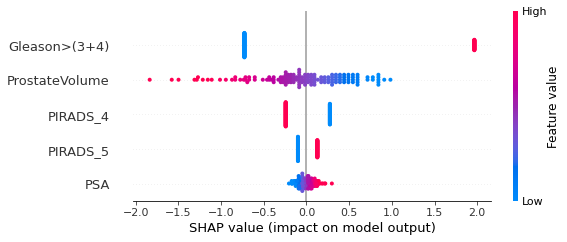




Clinical + Semantic features

AUCROC   (CV) = 0.887 ± 0.102
Accuracy (CV) = 0.835 ± 0.092
F1       (CV) = 0.625 ± 0.225

AUCROC   (test) = 0.888
Accuracy (test) = 0.745
F1       (test) = 0.533
p-value  (test) = 3e-06


Feature,Coeff,Freq,ICC
Gleason>(3+4),0.414,1.000,-
CapsularContactLength,0.333,1.000,0.693
IrregularContour,0.243,1.000,0.417
RetroprostaticAngleOblit,0.164,0.998,0.479
CapsularDisruption,0.075,0.925,0.352


                  Feature  Coeff   Freq    ICC
            Gleason>(3+4)  0.414  1.000      -
    CapsularContactLength  0.333  1.000  0.693
         IrregularContour  0.243  1.000  0.417
 RetroprostaticAngleOblit  0.164  0.998  0.479
       CapsularDisruption  0.075  0.925  0.352


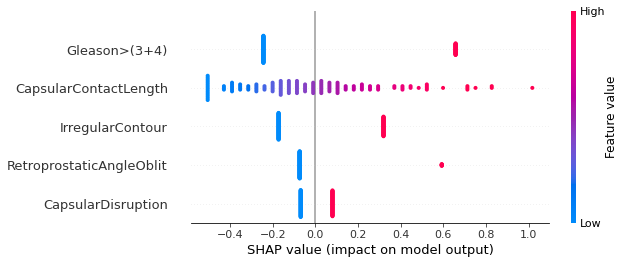




Clinical + Radiomic features

AUCROC   (CV) = 0.845 ± 0.121
Accuracy (CV) = 0.81 ± 0.099
F1       (CV) = 0.601 ± 0.222

AUCROC   (test) = 0.825
Accuracy (test) = 0.764
F1       (test) = 0.581
p-value  (test) = 8.8e-05


Feature,Coeff,Freq,ICC
Gleason>(3+4),0.843,1.000,-
firstorder_90Percentile,-0.366,0.708,0.935
ProstateVolume,-0.267,0.964,-
shape_MeshVolume,0.258,0.910,0.904
firstorder_Minimum,-0.242,0.867,0.773
glcm_DifferenceEntropy,-0.205,0.911,0.752


                 Feature  Coeff   Freq    ICC
           Gleason>(3+4)  0.843  1.000      -
 firstorder_90Percentile -0.366  0.708  0.935
          ProstateVolume -0.267  0.964      -
        shape_MeshVolume  0.258  0.910  0.904
      firstorder_Minimum -0.242  0.867  0.773
  glcm_DifferenceEntropy -0.205  0.911  0.752


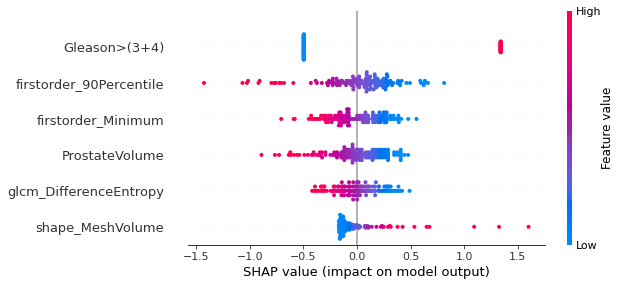




Clinical + Semantic + Radiomic features

AUCROC   (CV) = 0.88 ± 0.101
Accuracy (CV) = 0.826 ± 0.092
F1       (CV) = 0.609 ± 0.226

AUCROC   (test) = 0.928
Accuracy (test) = 0.782
F1       (test) = 0.6
p-value  (test) = 0.0


Feature,Coeff,Freq,ICC
Gleason>(3+4),0.648,1.000,-
RetroprostaticAngleOblit,0.424,1.000,0.479
IrregularContour,0.411,1.000,0.417
CapsularContactLength,0.367,0.995,0.693
CapsularDisruption,0.235,0.988,0.352
ProstateVolume,-0.177,0.939,-
AnatDev03,0.155,0.914,0.409
firstorder_Minimum,-0.129,0.693,0.773
shape_MeshVolume,0.111,0.863,0.904
firstorder_10Percentile,-0.069,0.675,0.940


                  Feature  Coeff   Freq    ICC
            Gleason>(3+4)  0.648  1.000      -
 RetroprostaticAngleOblit  0.424  1.000  0.479
         IrregularContour  0.411  1.000  0.417
    CapsularContactLength  0.367  0.995  0.693
       CapsularDisruption  0.235  0.988  0.352
           ProstateVolume -0.177  0.939      -
                AnatDev03  0.155  0.914  0.409
       firstorder_Minimum -0.129  0.693  0.773
         shape_MeshVolume  0.111  0.863  0.904
  firstorder_10Percentile -0.069  0.675   0.94


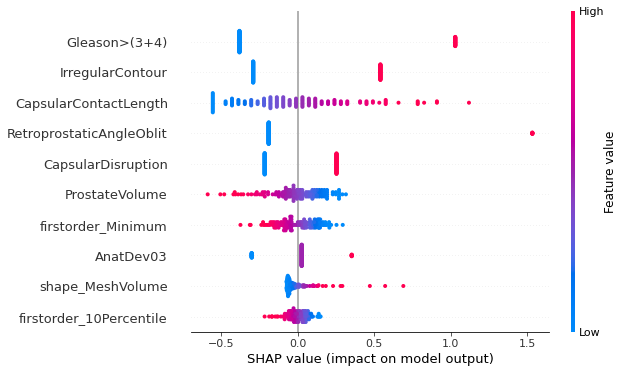

In [15]:
removeList = [measECEskip, 'semantic_Gleason x mECE', 'clinical_Gleason x PIRADS_5', 'clinical_Gleason x PIRADS_4']

# generate the tabular outputs and SHAP plots
models = runAllModels(permutationTest=False, removeList=removeList)

In [16]:
testData = models['clin']['yTest']

m1 = models['clin']
m2 = models['clinSem']
pValue = 10**delong_roc_test(testData, m1['test_score'], m2['test_score'])[0,0]
print('\nDelong comparing ' + m1['label'] + ' vs. ' + m2['label'] + '\np = ' + str(np.round(pValue,3)))

m1 = models['clin']
m2 = models['clinRad']
pValue = 10**delong_roc_test(testData, m1['test_score'], m2['test_score'])[0,0]
print('\nDelong comparing ' + m1['label'] + ' vs. ' + m2['label'] + '\np = ' + str(np.round(pValue,3)))

m1 = models['clin']
m2 = models['clinSemRad']
pValue = 10**delong_roc_test(testData, m1['test_score'], m2['test_score'])[0,0]
print('\nDelong comparing ' + m1['label'] + ' vs. ' + m2['label'] + '\np = ' + str(np.round(pValue,3)))


Delong comparing Clinical vs. Clinical + Semantic
p = 0.089

Delong comparing Clinical vs. Clinical + Radiomic
p = 0.104

Delong comparing Clinical vs. Clinical + Semantic + Radiomic
p = 0.017


# Make some plots

In [17]:
from sklearn.model_selection import RepeatedKFold

def noMeasECEmodelCV(df, ptArr, n_splits=10, n_repeats=10):

    X = df[measECEskip].copy()
    y = df[target].copy()

    netBenefitCurve = np.zeros(ptArr.shape)
    rocCurveX = np.zeros(ptArr.shape)
    rocCurveY = np.zeros(ptArr.shape)
    rocAUC = 0
    count = 0
    
    validation = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    
    for train_index, test_index in validation.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        tn, fp, fn, tp = confusion_matrix(y_train, X_train, labels=[0,1]).ravel()
        p0 = fn/(tn+fn)
        p1 = tp/(tp+fp)
        scoreTest = np.zeros(X_test.shape[0])
        scoreTest[X_test==0] = p0
        scoreTest[X_test==1] = p1

        tn, fp, fn, tp = confusion_matrix_thresholds(y_test, scoreTest, ptArr)
        netBenefitCurve += (tp - fp * (ptArr / (1 - ptArr))) / len(y_test)
        if np.all((tn+fp)>0) and np.all(tp+fn):
            rocCurveXh = 1 - tn/(tn+fp)
            rocCurveYh = tp/(tp+fn)
            rocCurveX += rocCurveXh
            rocCurveY += rocCurveYh
            rocAUC += np.sum(-np.diff(rocCurveXh)*0.5*(rocCurveYh[0:-1] + rocCurveYh[1:]))
            count += 1
    netBenefitCurve /= count
    rocCurveX /= count
    rocCurveY /= count
    rocAUC /= count
    return netBenefitCurve, rocCurveX, rocCurveY, rocAUC

In [18]:
# get threshold array pt from any model
thresh = np.unique(models['clin']['DCA_CV']['thresholds'])
thresh = np.append(thresh, 1e-6)
thresh = np.append(thresh, 1-1e-6)
thresh = np.sort(thresh)

# cross-validate the noMeasECE model in the training data
# netBenefitCurveCV, rocCurveX_CV, rocCurveY_CV, rocAUC_CV = noMeasECEmodelCV(dfTrain, thresh, n_splits=n_splits, n_repeats=n_repeats)

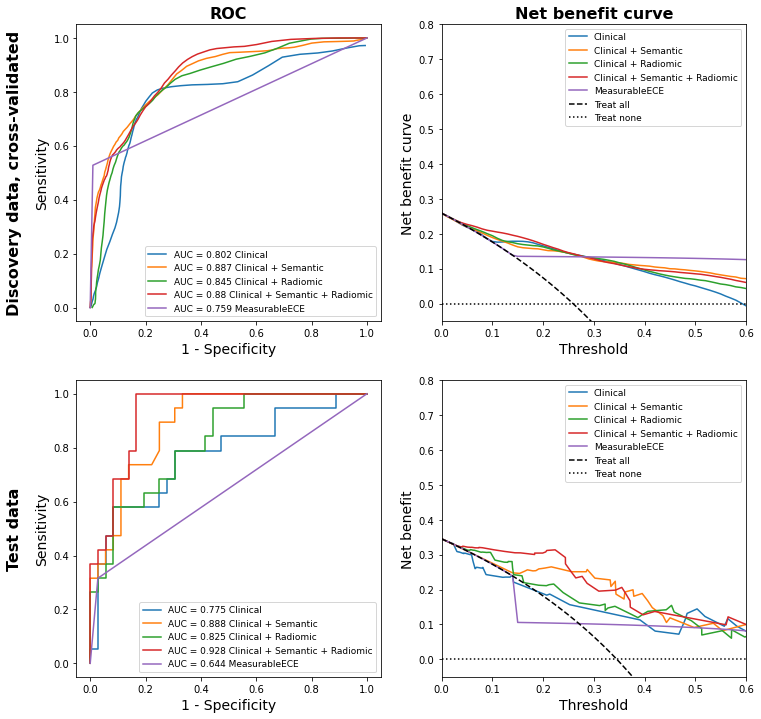

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
ax = ax.ravel()

# noMeasECE model derived from training data
tn, fp, fn, tp = confusion_matrix(dfTrain[target], dfTrain[measECEskip]).ravel()
p0mECE = fn/(tn+fn) # Pr(noECE=True | noMeasECE=False)
p1mECE = tp/(tp+fp) # Pr(noECE=True | noMeasECE=True)

scoreTrain = np.zeros(dfTrain.shape[0])
scoreTrain[dfTrain[measECEskip]==0] = p0mECE
scoreTrain[dfTrain[measECEskip]==1] = p1mECE
tn, fp, fn, tp = confusion_matrix_thresholds(dfTrain[target], scoreTrain, thresh)
netBenefitTrain = (tp - fp * (thresh / (1 - thresh))) / len(dfTrain[target])
rocXtrain = 1 - tn/(tn+fp)
rocYtrain = tp/(tp+fn)
aucTrain = roc_auc_score(dfTrain[target], scoreTrain)

scoreTest = np.zeros(dfTest.shape[0])
scoreTest[dfTest[measECEskip]==0] = p0mECE
scoreTest[dfTest[measECEskip]==1] = p1mECE
tn, fp, fn, tp = confusion_matrix_thresholds(dfTest[target], scoreTest, thresh)
netBenefitTest = (tp - fp * (thresh / (1 - thresh))) / len(dfTest[target])
rocXtest = 1 - tn/(tn+fp)
rocYtest = tp/(tp+fn)

# discovery data plots

# ROC
for r in models.values():
    ax[0].plot(r['FPR_CV']['values'], 
               [1-x for x in r['FNR_CV']['values']], 
               label = 'AUC = ' + str(np.round(r['AUC_CV'],3)) + ' ' + r['label'])

ax[0].plot(rocXtrain, rocYtrain, label='AUC = ' + str(np.round(aucTrain,3)) + ' MeasurableECE')
# ax[0].plot(rocCurveX_CV, rocCurveY_CV, label='AUC = ' + str(np.round(rocAUC_CV,3)) + ' MeasurableECE CV')


ax[0].set_xlabel('1 - Specificity', fontsize=14)
ax[0].set_ylabel('Sensitivity', fontsize=14)
ax[0].set_title('ROC', fontsize=16, fontweight='bold')
ax[0].text(-0.3, 0.5, 'Discovery data, cross-validated', fontsize=16, fontweight='bold', rotation=90, verticalalignment='center')
ax[0].legend(fontsize=9)

# DCA
TPtrain = np.sum(dfTrain[target]==1)/dfTrain.shape[0]
FPtrain = np.sum(dfTrain[target]==0)/dfTrain.shape[0]
for r in models.values():
    exactScale = TPtrain/r['DCA_CV']['values'][0]
    ax[1].plot(r['DCA_CV']['thresholds'], [x*exactScale for x in r['DCA_CV']['values']], label=r['label'])
ax[1].plot(thresh, netBenefitTrain, label='MeasurableECE')
# ax[1].plot(thresh, netBenefitCurveCV, label='MeasurableECE CV')

# add treat all and treat none
ax[1].plot(thresh, (TPtrain - FPtrain*thresh/(1-thresh)), label='Treat all', color='k', linestyle='--')
ax[1].plot([0, 1], [0, 0], label='Treat none', color='k', linestyle=':')


ax[1].set_title('Net benefit curve', fontsize=16, fontweight='bold')
ax[1].legend(fontsize=9)
ax[1].set_xlabel('Threshold', fontsize=14)
ax[1].set_ylabel('Net benefit curve', fontsize=14)
ax[1].set_ylim([-0.05, 0.8])
ax[1].set_xlim([0, 0.6])

# test data plots

# ROC
for r in models.values():
    fpr, tpr, _ = roc_curve(r['yTest'], r['test_score'])
    ax[2].plot(fpr, tpr, label='AUC = ' + str(np.round(r['test_AUC'],3)) + ' ' + r['label'])
ax[2].set_xlabel('1 - Specificity', fontsize=14)
ax[2].set_ylabel('Sensitivity', fontsize=14)
ax[2].text(-0.3, 0.5, 'Test data', fontsize=16, fontweight='bold', rotation=90, verticalalignment='center')


fpr, tpr, _ = roc_curve(dfTest[target], scoreTest)
aucTest = roc_auc_score(dfTest[target], scoreTest)
ax[2].plot(fpr, tpr, label='AUC = ' + str(np.round(aucTest,3)) + ' MeasurableECE')


ax[2].legend(fontsize=9)

# DCA
for r in models.values():
    thr = np.unique(r['test_score'])
    thr = np.append(thr, 1e-6)
    thr = np.append(thr, 1-1e-6)
    thr = np.sort(thr)
    tn, fp, fn, tp = confusion_matrix_thresholds(r['yTest'], r['test_score'], thr)
    ax[3].plot(thr, (tp - fp * (thr / (1 - thr))) / len(r['yTest']), label=r['label'])
ax[3].plot(thresh, netBenefitTest, label='MeasurableECE')
ax[3].plot(thresh, (tp[0] - fp[0] * (thresh / (1 - thresh))) / len(r['yTest']), label='Treat all', color='k', linestyle='--')
ax[3].plot([0, 1], [0, 0], label='Treat none', color='k', linestyle=':')

ax[3].legend(fontsize=9)
ax[3].set_xlabel('Threshold', fontsize=14)
ax[3].set_ylabel('Net benefit', fontsize=14)
ax[3].set_ylim([-0.05, 0.8])
ax[3].set_xlim([0, 0.6])


figFile = os.path.join(outputFolderFigures, 'ROC_NetBenefit_wide.pdf')
plt.savefig(figFile)
plt.show()

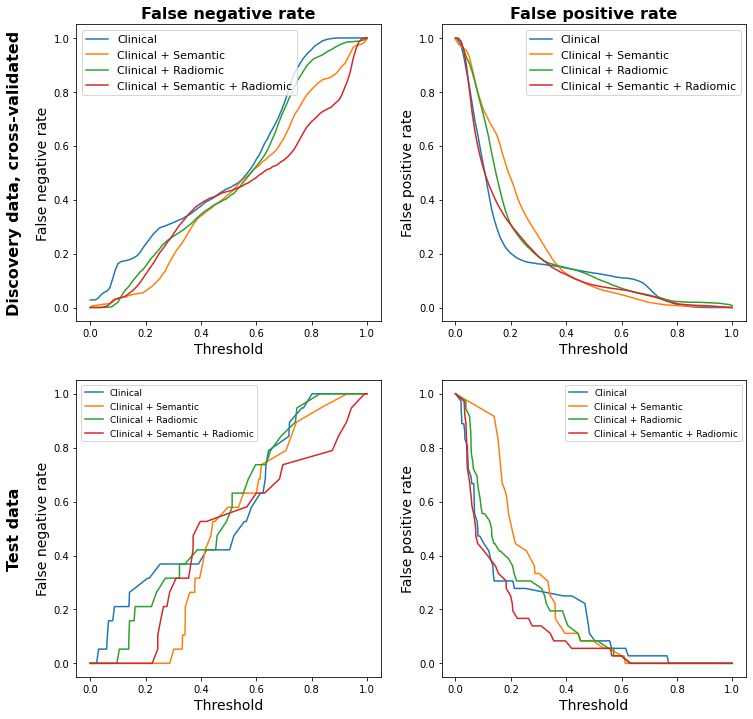

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
ax = ax.ravel()

# discovery data plots

# FNR
for r in models.values():
    ax[0].plot(r['FNR_CV']['thresholds'], r['FNR_CV']['values'], label=r['label'])
ax[0].set_title('False negative rate', fontsize=16, fontweight='bold')
ax[0].legend(fontsize=11)
ax[0].set_xlabel('Threshold', fontsize=14)
ax[0].set_ylabel('False negative rate', fontsize=14)
ax[0].text(-0.3, 0.5, 'Discovery data, cross-validated', fontsize=16, fontweight='bold', rotation=90, verticalalignment='center')

# FPR
for r in models.values():
    ax[1].plot(r['FPR_CV']['thresholds'], r['FPR_CV']['values'], label=r['label'])
ax[1].set_title('False positive rate', fontsize=16, fontweight='bold')
ax[1].legend(fontsize=11)
ax[1].set_xlabel('Threshold', fontsize=14)
ax[1].set_ylabel('False positive rate', fontsize=14)


# test data plots

# FNR, FPR and DCA
for r in models.values():
    thresh = np.unique(r['test_score'])
    thresh = np.append(thresh, 1e-6)
    thresh = np.append(thresh, 1-1e-6)
    thresh = np.sort(thresh)
    tn, fp, fn, tp = confusion_matrix_thresholds(r['yTest'], r['test_score'], thresh)
    ax[2].plot(thresh, fn/(fn + tp), label=r['label'])
    ax[3].plot(thresh, fp/(fp + tn), label=r['label'])

ax[2].text(-0.3, 0.5, 'Test data', fontsize=16, fontweight='bold', rotation=90, verticalalignment='center')

for axi in [2, 3]:
    ax[axi].legend(fontsize=9)
    ax[axi].set_xlabel('Threshold', fontsize=14)

ax[2].set_ylabel('False negative rate', fontsize=14)
ax[3].set_ylabel('False positive rate', fontsize=14)

figFile = os.path.join(outputFolderFigures, 'FP_FN.pdf')
plt.savefig(figFile)
plt.show()

In [21]:
%%capture

# save current state of notebook and wait a bit as the actual save happens with a short delay
display(Javascript('IPython.notebook.save_checkpoint();'))
sleep(10)

# copy notebook again
shutil.copyfile(notebookPath, notebookDestin)